In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect, func
import sqlite3

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:////Users/carleighwest/Desktop/sqlalchemy-challenge/Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
inspector = inspect(engine)
# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [17]:
# View all of the columns in 'measurement'
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
# View all of the columns in 'station'
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# automap database into class
Base = automap_base()
Base.prepare(autoload_with=engine)

In [20]:
# make sure all tables were mapped
#Base.classes.keys()

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

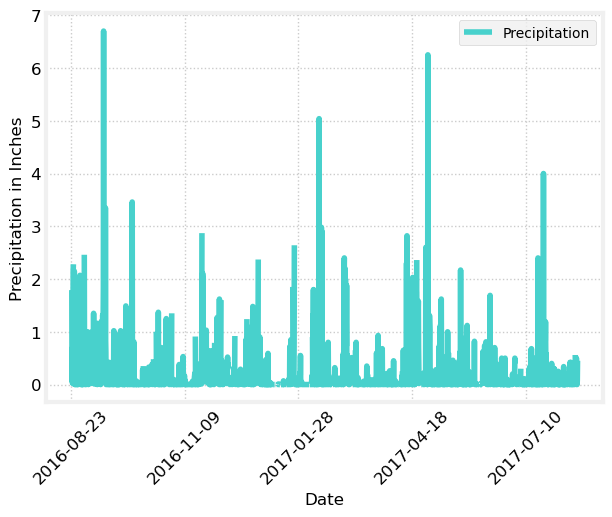

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', rot=45, color='mediumturquoise', fontsize=12)
plt.gca().set_facecolor('white') 
plt.gcf().set_facecolor('white')
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', linewidth=1)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation in Inches", fontsize=12)
plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe().round(3)

,Precipitation
count,2021.000
mean,0.177
std,0.461
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [27]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

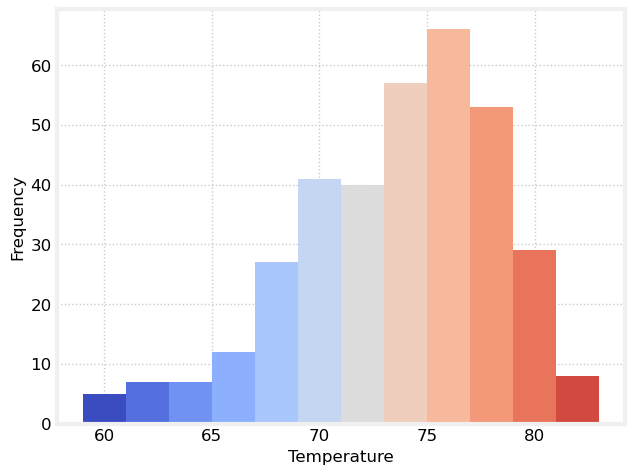

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= prev_year).all()

# put the results into a dataframe
df = pd.DataFrame(results, columns=['Tobs'])

# get the bins and counts to create the histogram
counts, bins = np.histogram(df['Tobs'], bins=12)

# normalize the bins to use a colormap
# the plt.Normalize() function is used to normalize the bin edges so that they can be mapped to the color scale
# the plt.cm.coolwarm function retrieves colors from the "coolwarm" colormap, which transitions from cool colors (blue) to warm colors (red)
norm = plt.Normalize(bins.min(), bins.max())
colors = plt.cm.coolwarm(norm(bins[:-1]))

# use a for loop so each column will correlate with the colormap
# using a loop to plot each bar individually with plt.bar() allows you to assign a different color from the colormap to each bar based on its corresponding bin
for count, color, bin_edge in zip(counts, colors, bins[:-1]):
    plt.bar(bin_edge, count, width=np.diff(bins), color=color, linewidth=1.2, align='edge')

# plot the histogram
plt.gca().set_facecolor('white') 
plt.gcf().set_facecolor('white')
plt.grid(True, linestyle=':', linewidth=1)
plt.tight_layout()
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

# Close Session

In [30]:
# Close Session
session.close()